In [2]:
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import string
import unicodedata
import re
import numpy as np
import os
import io
import time
punctuations = set(string.punctuation)
not_punc = ".?!,|"
print("Before : ", punctuations)
for c in not_punc:
   punctuations.remove(c)
print("After : ", punctuations)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Before :  {')', '?', '%', '_', '$', '"', '-', '}', '\\', '+', '|', '#', '=', '/', '~', '@', '[', '*', ':', ';', '`', ']', '>', '(', '<', ',', "'", '!', '{', '^', '&', '.'}
After :  {')', '%', '_', '$', '"', '-', '}', '\\', '+', '#', '=', '/', '~', '@', '[', '*', ':', ';', '`', ']', '>', '(', '<', "'", '{', '^', '&'}


In [18]:
df = pd.read_csv('English_hindi.csv', encoding='utf-8') #https://raw.githubusercontent.com/prismspeechproject/neural/master/implementation/English_hindi.csv
df = df[df.columns[0:2]]
df.columns, df.shape

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(Index(['English', 'Hindi'], dtype='object'), (127607, 2))

In [19]:
df = df[~pd.isnull(df['English'])]
df.drop_duplicates(inplace=True)
df.shape

(124818, 2)

In [20]:
# Calculate number of words in each line of 2 columns
df['len_eng_words'] = df['English'].apply(lambda e: len(str(e).split(" ")))
df['len_hin_words'] = df['Hindi'].apply(lambda h: len(str(h).split(" ")))
df = df[df['len_eng_words']<=20]
df = df[df['len_hin_words']<=20]
max(df['len_eng_words']), max(df['len_hin_words'])

(20, 20)

In [21]:
df = df.sample(n=5000, random_state=42)
df.shape

(5000, 4)

In [22]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence_hindi(w):
    w = str(w).lower().strip()
    w = re.sub(r"[\(\[].*?[\)\]]", '', w)
    w = re.sub(r"[२३०८१५७९४६]", '', w)
    #creating a space between a word and punctuation 
    w = re.sub(r"([?!,|])", r' \1 ', w)
    w = re.sub(r'[" "]+', " ", w)
    w = ''.join(c for c in w if c not in punctuations)
            
    # # replacing everything with space except a-z A-Z ? . ! , |
    #w = re.sub(r'[^a-z?|!,]', " ", w)
    w = w.strip()

    w = '<start> ' + w + ' <end>'
    return w

def preprocess_sentence_eng(w):#https://www.tfaforms.com/4844143
    w = unicode_to_ascii(str(w).lower().strip())
    w = re.sub(r"[\(\[].*?[\)\]]", '', w)
    #creating a space between a word and punctuation 
    w = re.sub(r"([.?!,])", r' \1 ', w)
    w = re.sub(r'[" "]+', " ", w)

    # # replacing everything with space except a-z A-Z ? . ! , |
    w = re.sub(r'[^a-zA-Z?.!,]+', " ", w)

    w = w.strip()

    w = '<start> ' + w + ' <end>'
    return w

In [23]:
def customize_dataset(df):
    df['English'] = df['English'].apply(lambda e : preprocess_sentence_eng(e))
    df['Hindi'] = df['Hindi'].apply(lambda h : preprocess_sentence_hindi(h))

    return df['English'], df['Hindi']

In [24]:
def tokenizer(data_sen):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(data_sen)

    tensor = lang_tokenizer.texts_to_sequences(data_sen)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [25]:
def load_dataset(df):
    input_lang, target_lang = customize_dataset(df)

    input_tf, input_lang_tokenizer = tokenizer(input_lang)
    target_tf, target_lang_tokenizer = tokenizer(target_lang)

    return input_tf, target_tf, input_lang_tokenizer, target_lang_tokenizer


In [26]:
input_tf, target_tf, input_lang_tokenizer, target_lang_tokenizer = load_dataset(df)

max_input_len , max_target_len = input_tf.shape[1], target_tf.shape[1]

In [27]:
# Creating Train test split
input_tf_train, input_tf_test, target_tf_train, target_tf_test = train_test_split(input_tf, target_tf, test_size=0.2)

len(input_tf_train), len(input_tf_test), len(target_tf_train), len(target_tf_test)

(4000, 1000, 4000, 1000)

In [28]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
           print(f'{t} ----> {lang.index_word[t]}')

print('Input lang : index to word mapping')
convert(input_lang_tokenizer, input_tf_train[0])

print('target lang : index to word mapping')
convert(target_lang_tokenizer, target_tf_train[0])

Input lang : index to word mapping
1 ----> <start>
680 ----> thank
17 ----> you
5089 ----> industrialization
3 ----> .
2 ----> <end>
target lang : index to word mapping
1 ----> <start>
6130 ----> “औद्योगिकीकरण
969 ----> धन्यवाद
32 ----> |
2 ----> <end>


In [29]:
# Creating Dataset
BUFFER_SIZE = len(input_tf_train)
BATCH_SIZE = 64
steps_per_epochs = len(input_tf_train)//BATCH_SIZE
embedding_dim = 256
units=1024
vocab_inp_size = len(input_lang_tokenizer.word_index) +1 
vocab_tar_size =  len(target_lang_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tf_train, target_tf_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [30]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape


(TensorShape([64, 32]), TensorShape([64, 25]))

In [31]:
 class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.vocab_size = vocab_size
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))


In [32]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size=BATCH_SIZE)

#Sample input 
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder Output (Batch_size, seq_len, units)', sample_output.shape)
print('Encoder Output (Batch_size, units)', sample_hidden.shape)

Encoder Output (Batch_size, seq_len, units) (64, 32, 1024)
Encoder Output (Batch_size, units) (64, 1024)


In [33]:
class BahadanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahadanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [34]:
attention_layer = BahadanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print('Attention result shape (Batch_size, units)', attention_result.shape)
print('Attention weights shape (Batch_size, seq_len, 1)', attention_weights.shape)


Attention result shape (Batch_size, units) (64, 1024)
Attention weights shape (Batch_size, seq_len, 1) (64, 32, 1)


In [35]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)    
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for Attenation
        self.attention = BahadanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_len, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [36]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)


Decoder output shape: (batch_size, vocab size) (64, 10008)


In [37]:
# Define optimizer and loss function 

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)

    loss_ *= mask
    return tf.reduce_mean(loss_)

In [38]:
checkpoint_dir = '/run/media/pacman/9C3D62B805200142/Neural'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [39]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epochs)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epochs:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp3q0jj2ih.py, line 28)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp3q0jj2ih.py, line 28)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1 Batch 0 Loss 3.9263
Epoch 1 Loss 3.2113
Time taken for 1 epoch 362.41 sec

Epoch 2 Batch 0 Loss 2.9643
Epoch 2 Loss 2.8992
Time taken for 1 epoch 297.38 sec

Epoch 3 Batch 0 Loss 3.2308
Epoch 3 Loss 2.7490
Time taken for 1 epoch 290.36 sec

Epoch 4 Batch 0 Loss 2.5722
Epoch 4 Loss 2.6016
Time taken for 1 epoch 295.07 sec

Epoch 5 Batch 0 Loss 2.2150
Epoch 5 Loss 2.4427
Time taken for 1

In [30]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_len, max_input_len))

  sentence = preprocess_sentence_eng(sentence)

  inputs = [input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_input_len,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], 0)

  for t in range(max_target_len):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_lang_tokenizer.index_word[predicted_id] + ' '

    if target_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


In [26]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [27]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [28]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> what is your name ? <end>
Predicted translation: ? क़्या है ? <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s

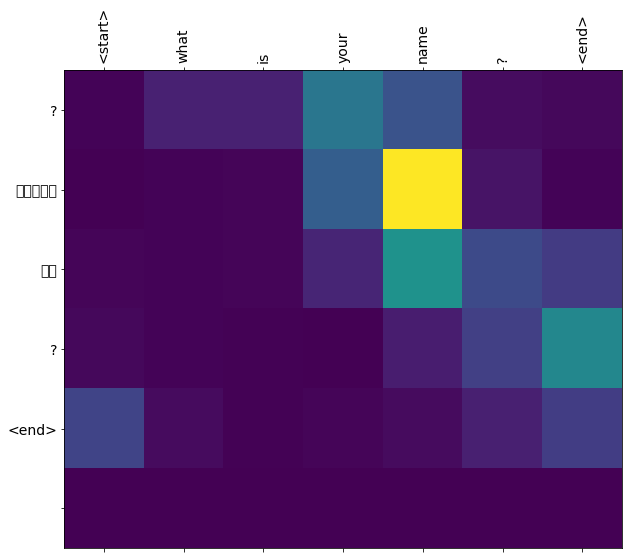

In [29]:
translate(u'what is your name?')
